In [2]:
# -----------------------------
# Block 1: Setup, Imports, Paths, and Strategy 
# -----------------------------

# Install keras-tuner
!pip install -q -U keras-tuner

# -----------------------------
# Imports
# -----------------------------
import os
os.environ['PYTHONHASHSEED'] = str(42)
import random, hashlib, shutil
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
import tensorflow_hub as hub

# Application preprocess imports 
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess_input

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# -----------------------------
# Register custom preprocessors
# -----------------------------
@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_efficientnet_preprocess(inputs):
    return efficientnet_v2_preprocess_input(inputs)

@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_vgg19_preprocess(inputs):
    return vgg19_preprocess_input(inputs)

@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_resnetv2_preprocess(inputs):
    return resnet_v2_preprocess_input(inputs)

@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_inception_preprocess(inputs):
    return inception_v3_preprocess_input(inputs)

@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_nasnet_preprocess(inputs):
    return nasnet_preprocess_input(inputs)

@tf.keras.utils.register_keras_serializable(package="CustomPreprocessing")
def custom_xception_preprocess(inputs):
    return xception_preprocess_input(inputs)

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# -----------------------------
# Strategy & GPU setup (Kaggle single-GPU friendly)
# -----------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.enable_op_determinism()
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass
    try:
        STRATEGY = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    except Exception:
        STRATEGY = tf.distribute.get_strategy()
else:
    STRATEGY = tf.distribute.get_strategy()

print("Devices:", tf.config.list_logical_devices())
print("Using strategy:", STRATEGY.__class__.__name__)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

# -----------------------------
# Paths & Constants 
# -----------------------------
DATA_DIR = Path("/kaggle/input/state-farm-distracted-driver-detection")
TRAIN_DIR = DATA_DIR / "imgs" / "train"
TEST_DIR  = DATA_DIR / "imgs" / "test"
DRIVER_LIST_PATH = DATA_DIR / "driver_imgs_list.csv"

OUTPUT_DIR = Path("/kaggle/working/models")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (384, 384)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS_HEAD = 8
EPOCHS_FINETUNE = 42
AUTOTUNE = tf.data.AUTOTUNE

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)
print("Driver list CSV exists:", DRIVER_LIST_PATH.exists())

# -----------------------------
# Verify and load driver CSV
# -----------------------------
if DRIVER_LIST_PATH.exists():
    driver_list_df = pd.read_csv(DRIVER_LIST_PATH)
    print("\nDriver list loaded successfully!")
    print(driver_list_df.head())
else:
    print("\ndriver_imgs_list.csv not found — please verify dataset path!")

# -----------------------------
# Utilities: corrupted image removal
# -----------------------------
def remove_corrupted_images(folder: Path):
    """Detect and remove corrupted JPEG/PNG images in a folder recursively."""
    if not folder.exists():
        print(f"Folder {folder} not found; skipping corrupted-image check.")
        return
    print("Checking for corrupted images (this may take a while)...")
    count = 0
    image_paths = list(folder.rglob("*.jpg")) + list(folder.rglob("*.jpeg")) + list(folder.rglob("*.png"))
    for p in tqdm(image_paths):
        try:
            with Image.open(p) as im:
                im.verify()
        except (IOError, SyntaxError, UnidentifiedImageError, OSError):
            count += 1
            print("Removing corrupted:", p)
            try:
                p.unlink()
            except Exception as e:
                print(f"  Could not remove {p}: {e}")
    print(f"Removed {count} corrupted images.")

# -----------------------------
# Utilities: exact file-duplicate detection using SHA256
# -----------------------------
def remove_exact_duplicates(df: pd.DataFrame, hash_col='file_hash'):
    """Compute SHA256 hash for each filepath, drop exact duplicates, return deduped df."""
    print("Calculating SHA256 file hashes to detect exact duplicates...")

    def _hash_file(fp):
        h = hashlib.sha256()
        try:
            with open(fp, 'rb') as f:
                for chunk in iter(lambda: f.read(8192), b''):
                    h.update(chunk)
            return h.hexdigest()
        except Exception:
            return None

    tqdm.pandas(desc="Hashing files")
    df[hash_col] = df['filepath'].progress_apply(_hash_file)
    df = df[df[hash_col].notna()].reset_index(drop=True)

    original_count = len(df)
    unique_count = df[hash_col].nunique()
    if original_count > unique_count:
        removed = original_count - unique_count
        print(f"Found {removed} exact duplicate files → removing duplicates (keeping first).")
        df = df.drop_duplicates(subset=[hash_col], keep='first').reset_index(drop=True)
    else:
        print("No exact duplicates found.")

    return df.drop(columns=[hash_col])


Devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]
Using strategy: OneDeviceStrategy
TRAIN_DIR: /kaggle/input/state-farm-distracted-driver-detection/imgs/train
TEST_DIR: /kaggle/input/state-farm-distracted-driver-detection/imgs/test
Driver list CSV exists: True

Driver list loaded successfully!
  subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg


In [3]:
# -----------------------------
# Block 2: Data Preparation, tf.data Pipeline, and Class Weights 
# -----------------------------
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
import tensorflow as tf

# -----------------------------
# Locate Driver CSV even if dataset structure differs
# -----------------------------
possible_paths = [
    DATA_DIR / "driver_imgs_list.csv",
    DATA_DIR / "driver_imgs_list.csv.gz",
    DATA_DIR / "img" / "driver_imgs_list.csv",
    DATA_DIR / "driver_imgs_list" / "driver_imgs_list.csv"
]

DRIVER_LIST_PATH = None
for p in possible_paths:
    if p.exists():
        DRIVER_LIST_PATH = p
        break

if DRIVER_LIST_PATH is None:
    raise FileNotFoundError(
        "driver_imgs_list.csv NOT found! Check dataset folder structure using:\n"
        "!ls -R /kaggle/input/state-farm-distracted-driver-detection"
    )

print("Using driver list:", DRIVER_LIST_PATH)

# -----------------------------
# 1) Build DataFrame from driver list CSV 
# -----------------------------
def statefarm_make_df_from_csv(driver_list_path: Path, base_train_dir: Path):
    """Construct df with columns ['filepath','label','driver_id']"""
    df = pd.read_csv(driver_list_path)
    df = df.rename(columns={'subject': 'driver_id', 'classname': 'class_name', 'img': 'img_name'})
    df['label'] = df['class_name'].str.replace('c', '').astype(int)
    df['filepath'] = df.apply(lambda r: str(Path(base_train_dir) / r['class_name'] / r['img_name']), axis=1)

    # Keep only valid paths
    df = df[df['filepath'].apply(lambda x: Path(x).exists())].reset_index(drop=True)
    return df[['filepath', 'label', 'driver_id']]

# -----------------------------
# 2) Prepare DataFrame and cleaning
# -----------------------------
df = statefarm_make_df_from_csv(DRIVER_LIST_PATH, TRAIN_DIR)
print(f"Initial dataset size (existing files): {len(df)}")

# Remove corrupted images
remove_corrupted_images(TRAIN_DIR)

df = statefarm_make_df_from_csv(DRIVER_LIST_PATH, TRAIN_DIR)
print(f"Dataset size after removing corrupted files: {len(df)}")

# Remove exact duplicates
df = remove_exact_duplicates(df)
print(f"Dataset size after deduplication: {len(df)}")

# Save cleaned dataset
CLEAN_DATA_PATH = OUTPUT_DIR / "cleaned_full_dataframe.csv"
df.to_csv(CLEAN_DATA_PATH, index=False)
print(f"Cleaned DataFrame saved to: {CLEAN_DATA_PATH}")

# -----------------------------
# 3) Driver-group-wise Train/Val Split
# -----------------------------
def group_stratified_split(df: pd.DataFrame, group_col="driver_id", stratify_col="label", val_size=0.20, seed=SEED):
    splitter = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed)
    groups = df[group_col].astype('category').cat.codes
    train_idx, val_idx = next(splitter.split(df, groups=groups, y=df[stratify_col]))
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[val_idx].reset_index(drop=True)

train_df, val_df = group_stratified_split(df, group_col="driver_id", stratify_col="label")
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

print("Train label distribution:")
display(train_df['label'].value_counts().sort_index())

# -----------------------------
# 4) tf.data pipeline
# -----------------------------
# Mild & realistic augmentations
rand_flip = tf.keras.layers.RandomFlip("horizontal")
rand_rot = tf.keras.layers.RandomRotation(0.15, fill_mode='reflect')     
rand_zoom = tf.keras.layers.RandomZoom(0.15)                             
rand_trans = tf.keras.layers.RandomTranslation(0.06, 0.06)
rand_contrast = tf.keras.layers.RandomContrast(0.1)
rand_brightness = tf.keras.layers.RandomBrightness(0.1)

def data_augment(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = rand_flip(image)
    image = rand_rot(image)
    image = rand_zoom(image)
    image = rand_trans(image)
    image = rand_contrast(image)
    image = rand_brightness(image)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    return image, label

def decode_and_preprocess_img(img_path, label=None):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) 
    if label is None:
        return img
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def create_tf_dataset(df, is_training=True):
    filepaths = df['filepath'].astype(str).to_numpy()
    labels = df['label'].astype(int).to_numpy()
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def decode_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)  
        label = tf.one_hot(label, NUM_CLASSES)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)

    if is_training:
        def augment(img, label):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_saturation(img, 0.8, 1.2)
            return img, label

        ds = ds.shuffle(buffer_size=2048, seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return ds


train_ds = create_tf_dataset(train_df, is_training=True)
val_ds = create_tf_dataset(val_df, is_training=False)

#----------------------------
# 5) Steps per epoch & class weights
# -----------------------------
STEPS_PER_EPOCH = len(train_df) // BATCH_SIZE
VAL_STEPS = len(val_df) // BATCH_SIZE

cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(cw))

print("\nClass Weights:", class_weights)
print(f"STEPS_PER_EPOCH: {STEPS_PER_EPOCH}, VAL_STEPS: {VAL_STEPS}")

Using driver list: /kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv
Initial dataset size (existing files): 34924
Checking for corrupted images (this may take a while)...


100%|██████████| 17462/17462 [01:35<00:00, 182.31it/s]


Removed 0 corrupted images.
Dataset size after removing corrupted files: 34924
Calculating SHA256 file hashes to detect exact duplicates...


Hashing files: 100%|██████████| 34924/34924 [00:29<00:00, 1173.09it/s]


Found 17462 exact duplicate files → removing duplicates (keeping first).
Dataset size after deduplication: 17462
Cleaned DataFrame saved to: /kaggle/working/models/cleaned_full_dataframe.csv
Train: 13936, Val: 3526
Train label distribution:


label
0    1580
1    1394
2    1418
3    1447
4    1435
5    1425
6    1452
7    1219
8    1173
9    1393
Name: count, dtype: int64


Class Weights: {0: 0.8820253164556962, 1: 0.999713055954089, 2: 0.9827926657263751, 3: 0.9630960608154803, 4: 0.9711498257839721, 5: 0.9779649122807017, 6: 0.9597796143250689, 7: 1.1432321575061526, 8: 1.1880647911338449, 9: 1.0004307250538407}
STEPS_PER_EPOCH: 435, VAL_STEPS: 110


In [4]:
# ======================================================
# Block 3 : EfficientNetV2M - Hyperparameter Tuning (Load if available, else run)
# ======================================================
from tensorflow.keras.applications import EfficientNetV2M
import tensorflow as tf
from keras import backend as K
import json, os
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Define HyperModel for EfficientNetV2M
# -----------------------------
def build_efficientnetv2m_model(hp):
    with STRATEGY.scope():
        base_model = EfficientNetV2M(
            include_top=False,
            weights='imagenet',
            input_shape=(*IMG_SIZE, 3)
        )
        base_model.trainable = False  

        inputs = keras.Input(shape=(*IMG_SIZE, 3))
        x = custom_efficientnet_preprocess(inputs) 
        x = base_model(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)

        # -----------------------------
        # Define tunable hyperparameters
        # -----------------------------
        dropout_rate = hp.Float("dropout", 0.3, 0.6, step=0.1)  
        lr = hp.Choice("lr", [3e-4, 2e-4, 1e-4, 5e-5])          
        opt_choice = hp.Choice("optimizer", ["adamw", "adam", "rmsprop","sgd"])  

        # -----------------------------
        # Model head
        # -----------------------------
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
        model = keras.Model(inputs, outputs)

        # -----------------------------
        # Optimizer setup
        # -----------------------------
        if opt_choice == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=lr)
        elif opt_choice == "adamw":
            optimizer = keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
        elif opt_choice == "rmsprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=lr, momentum=0.9)
        elif opt_choice == "sgd":
            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

# -----------------------------
# Load or Run HPT
# -----------------------------
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
hp_path = "/kaggle/input/hpt-models/efficientnetv2m_best_hparams.json"
new_hp_path = OUTPUT_DIR / "efficientnetv2m_best_hparams.json"

if os.path.exists(hp_path):
    # Case 1: Use existing HPT file
    print(f"Found existing hyperparameters file: {hp_path}")
    with open(hp_path, "r") as f:
        best_hp_efficientnet_values = json.load(f)

else:
    # Case 2: Run new tuning automatically
    print("No existing hyperparameters found. Running new tuning...")

    tuner_efficientnet = kt.Hyperband(
        build_efficientnetv2m_model,
        objective='val_accuracy',
        max_epochs=8,   # EfficientNet converges fast
        factor=3,
        directory=str(OUTPUT_DIR / "tuner_efficientnetv2m"),
        project_name='efficientnetv2m_tuning',
        overwrite=True
    )

    stop_early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    tuner_efficientnet.search(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        epochs=8,
        class_weight=class_weights,
        callbacks=[stop_early],
        verbose=1
    )

    best_hp_efficientnet = tuner_efficientnet.get_best_hyperparameters(num_trials=1)[0]
    best_hp_efficientnet_values = best_hp_efficientnet.values

    with open(new_hp_path, "w") as f:
        json.dump(best_hp_efficientnet_values, f, indent=4)
    print(f"Saved new hyperparameters to: {new_hp_path}")

# -----------------------------
# Display Loaded/Found Hyperparameters
# -----------------------------
print("\nBest hyperparameters for EfficientNetV2M:")
for k, v in best_hp_efficientnet_values.items():
    print(f"  {k}: {v}")


Found existing hyperparameters file: /kaggle/input/hpt-models/efficientnetv2m_best_hparams.json

Best hyperparameters for EfficientNetV2M:
  lr: 0.0002
  dropout: 0.4
  optimizer: adamw


In [5]:
# ======================================================
# Block 4 : EfficientNetV2M - Fine-Tuning & Evaluation
# ======================================================
import os, json, numpy as np, tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras import layers, regularizers, mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Custom L3 Regularizer
# -----------------------------
import tensorflow as tf
from tensorflow.keras import backend as K

class L3Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, l3=1e-6):
        self.l3 = l3

    def __call__(self, x):
        return self.l3 * tf.reduce_sum(tf.abs(x) ** 3)

    def get_config(self):
        return {'l3': float(self.l3)}

# -----------------------------
# Build Model using Best HPs
# -----------------------------
with STRATEGY.scope():
    base_model = EfficientNetV2M(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False  # Freeze base for warm-up

    inputs = keras.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
    x = custom_efficientnet_preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(dtype=tf.float32)(x)
    x = layers.Dense(
        512,
        activation='relu',
        kernel_regularizer=regularizers.l2(2e-4),          # L2 for weight magnitude
        activity_regularizer=regularizers.l1(1e-5),        # L1 for sparsity
        bias_regularizer=L3Regularizer(1e-6),              # Custom L3 for aggressive overfitting control
        dtype=tf.float32
    )(x)

    x = layers.Dropout(best_hp_efficientnet_values.get("dropout", 0.4))(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype=tf.float32)(x)

    model = keras.Model(inputs, outputs)

    # -----------------------------
    # Step 1: Warm-up (Train Top Layers Only)
    # -----------------------------
    lr_warmup = best_hp_efficientnet_values.get("lr", 2e-4)
    optimizer_choice = best_hp_efficientnet_values.get("optimizer", "adamw").lower()

    if optimizer_choice == "adamw":
        optimizer_head = mixed_precision.LossScaleOptimizer(
            tf.keras.optimizers.AdamW(learning_rate=lr_warmup, weight_decay=1e-4)
        )
    elif optimizer_choice == "adam":
        optimizer_head = mixed_precision.LossScaleOptimizer(
            tf.keras.optimizers.Adam(learning_rate=lr_warmup)
        )
    elif optimizer_choice == "rmsprop":
        optimizer_head = mixed_precision.LossScaleOptimizer(
            tf.keras.optimizers.RMSprop(learning_rate=lr_warmup, momentum=0.9)
        )
    else:
        optimizer_head = mixed_precision.LossScaleOptimizer(
            tf.keras.optimizers.AdamW(learning_rate=2e-4, weight_decay=1e-4)
        )

    model.compile(
        optimizer=optimizer_head,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nStarting Warm-up Training (Frozen Base)...")
    history_warmup = model.fit(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        epochs=EPOCHS_HEAD,
        class_weight=class_weights,
        verbose=1
    )

    # -----------------------------
    # Step 2: Fine-Tuning (Unfreeze Top Layers)
    # -----------------------------
    # Unfreeze top layers of the base model
    fine_tune_at = len(base_model.layers) - 160 

    for i, layer in enumerate(base_model.layers):
        if i < fine_tune_at:
            layer.trainable = False
        elif isinstance(layer, layers.BatchNormalization):
            layer.trainable = False  
        else:
            layer.trainable = True
            
    optimizer_ft = mixed_precision.LossScaleOptimizer(
        tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)
    )

    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(optimizer=optimizer_ft, loss=loss_fn, metrics=['accuracy'])

    checkpoint_path = OUTPUT_DIR / "efficientnetv2m_best_model.keras"
    callbacks = [
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    ]

    print("\nStarting Fine-Tuning (Unfrozen Base Layers)...")
    history_finetune = model.fit(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        epochs=EPOCHS_FINETUNE,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

# -----------------------------
# Save Model & Training History
# -----------------------------
final_model_path = OUTPUT_DIR / "efficientnetv2m_finetuned_final.keras"
model.save(final_model_path)

history_dict = {
    "warmup": history_warmup.history,
    "finetune": history_finetune.history
}
hist_path = OUTPUT_DIR / "efficientnetv2m_training_history.json"
with open(hist_path, "w") as f:
    json.dump(history_dict, f)

print(f"\nFine-tuned EfficientNetV2M model saved to {final_model_path}")
print(f"Training history saved to {hist_path}")

# -----------------------------
# Evaluate Model on Validation Data
# -----------------------------
print("\nEvaluating Model on Validation Set...")
val_labels = np.concatenate([y for _, y in val_ds], axis=0)
y_true = np.argmax(val_labels, axis=1)
y_pred_probs = model.predict(val_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

final_acc = accuracy_score(y_true, y_pred) * 100
print(f"\nFinal Validation Accuracy: {final_acc:.2f}%")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Starting Warm-up Training (Frozen Base)...
Epoch 1/8


I0000 00:00:1762505918.473774      86 service.cc:148] XLA service 0x7d0ea800a8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762505918.474522      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762505918.474543      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762505921.054974      86 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762505952.252485      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


435/435 ━━━━━━━━━━━━━━━━━━━━ 157s 224ms/step - accuracy: 0.4819 - loss: 1.7477 - val_accuracy: 0.5534 - val_loss: 1.4879
Epoch 2/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 78s 178ms/step - accuracy: 0.7818 - loss: 0.9492 - val_accuracy: 0.5915 - val_loss: 1.3558
Epoch 3/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.8628 - loss: 0.7049 - val_accuracy: 0.6264 - val_loss: 1.3156
Epoch 4/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.8967 - loss: 0.5889 - val_accuracy: 0.6287 - val_loss: 1.2734
Epoch 5/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 78s 179ms/step - accuracy: 0.9239 - loss: 0.5060 - val_accuracy: 0.6608 - val_loss: 1.1743
Epoch 6/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.9325 - loss: 0.4553 - val_accuracy: 0.6574 - val_loss: 1.1662
Epoch 7/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 77s 178ms/step - accuracy: 0.9379 - loss: 0.4256 - val_accuracy: 0.6534 - val_loss: 1.2013
Epoch 8/8
435/435 ━━━━━━━━━━━━━━━━━━━━ 77s 177ms/step - accuracy: 0.9465 - loss: 0.3934 - val_accur

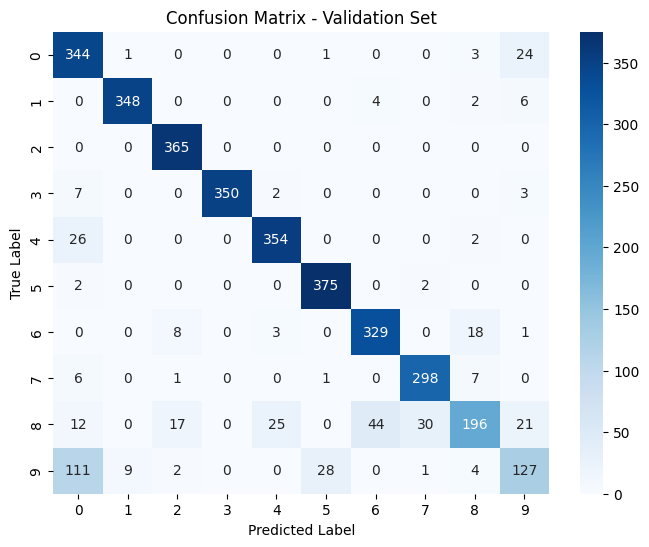

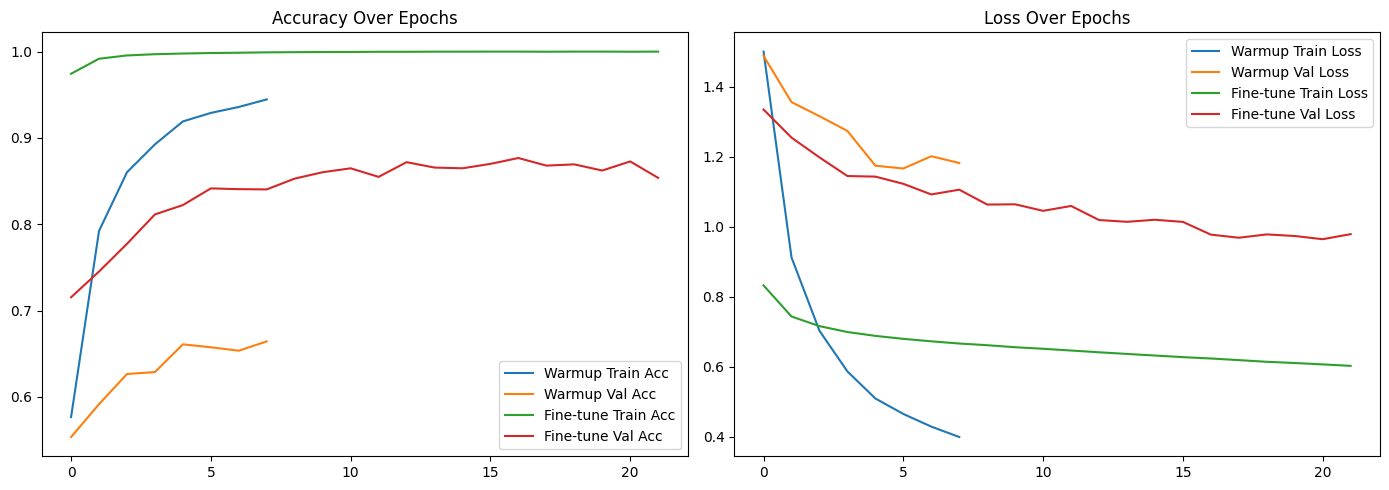

In [6]:
# -----------------------------
# Confusion Matrix
# -----------------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -----------------------------
# Training Curves
# -----------------------------
def plot_training_curves(history_dict):
    warm = history_dict["warmup"]
    finetune = history_dict["finetune"]

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(warm['accuracy'], label='Warmup Train Acc')
    plt.plot(warm['val_accuracy'], label='Warmup Val Acc')
    plt.plot(finetune['accuracy'], label='Fine-tune Train Acc')
    plt.plot(finetune['val_accuracy'], label='Fine-tune Val Acc')
    plt.title("Accuracy Over Epochs")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(warm['loss'], label='Warmup Train Loss')
    plt.plot(warm['val_loss'], label='Warmup Val Loss')
    plt.plot(finetune['loss'], label='Fine-tune Train Loss')
    plt.plot(finetune['val_loss'], label='Fine-tune Val Loss')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_dict)